In [2]:
import pandas as pd
import random
SEED = 42
random.seed(SEED)

In our project we will us different clustering models in order to perform the topic modelling. One of them is the Latent Dirichlet Allocation (LDA). It is an unsupervised machine-learning model. ‘Latent’ means that the model will discover hidden topics from the documents. ‘Dirichlet’ corresponds to the assumption made on the distribution of topics in a document and the distribution of words in topics, which are both assumed to be Dirichlet distributions. ‘Allocation’ for allocation of topics per documents and words of these documents per topics. LDA have 2 assumptions: first is that documents with similar topics will use similar words and the second is that each document is composed of words, which are assigned to different topics. Thus, documents are probability distributions over latent topics and topics are probability distributions over words. Using these assumptions LDA will assigns topics to documents. The output will represent the percentage of each topic and it for each topic it will output the frequency of each word. One should know that LDA doesn’t take in account the order of words and consider the documents as bag of words.

In [3]:
import io
df = pd.read_csv('winemag-data_first150k.csv')

As our dataset is very large, we use only 30000 observations.

In [4]:
df2=df['description']

#randomly selecting 30000 observations
df2=df2.sample(n=30000,random_state=1)

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim import corpora, models, similarities
import numpy as np
np.random.seed(2020) 

import nltk
nltk.download('wordnet')




C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Іванна\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocessing for LDA 

Before applying the model which will classify our reviews we need first preprocess all of those. First step is to lower case each word in the review, remove punctuation and tokenize (divide the text in simple words) it.  We do so using the function gensim.utils.simple_preprocess(). After this we remove the stopwords from our reviews using STOPWORDS from gensim.parsing.preprocessing. After this step we proceed with lemmatization, which is transforming the word into its meaningful base form. We also construct the bigrams and trigrams model, which assign probabilities to 2- and 3-word sequences accordingly. 

In [5]:
#lowercase and remove ponctuation for each document 
pr=[gensim.utils.simple_preprocess(d) for d in df2]
no_stop=[[t for t in i if t not in STOPWORDS] for i in pr]
#for the bigrams and the lemmatization function we use as reference the fucntion from the website below
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/?fbclid=IwAR1feBEBW4Gd6UcsVTjaHMKra5d9RbxMgbDwZn8TCv_deht7fsSrvKCpwdM
bigram = gensim.models.Phrases(no_stop, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[no_stop], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
words_bigrams=[bigram_mod[des] for des in no_stop]




C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [6]:
import spacy

After these preprocessing steps we try to display the wordcloud of all the words of all the documents. To do so we first transform our preprocessed descriptions of wine into a large list of strings and then we display the wordcloud:

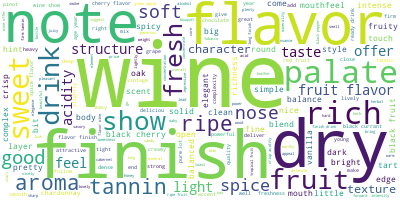

In [7]:
# lemmatize each token in each preprocessed document (review)
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
#processed_description = [[WordNetLemmatizer().lemmatize(t, pos='v') for t in i ] for i in words_bigrams]
processed_description = lemmatization(words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# create a wordcloud from the preprocessed document obtained in order to see which 
#words are the most frequent 
from wordcloud import WordCloud
flat_list = []
for sublist in processed_description:
    for item in sublist:
        flat_list.append(item)
#tansforming our flat list of words into one big string 
my_lst_str = " ".join(flat_list)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(my_lst_str)
# Visualize the word cloud, in order to see the words which are the most frequent in our document
wordcloud.to_image()

In order to apply the LDA model we need to remove some words which are common between the reviews. Such as ‘wine’, ‘flavor’ and ‘taste’. This is done in order to remove the noise which could possibly be created by these words. Now our wordcloud is represented in the form below.

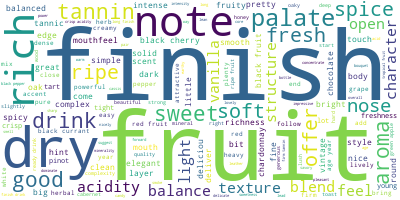

In [8]:
#word 'flavor' and 'taste' could prodcue some nice in our LDA model, 
#that is why we remove those words from our review too

my_stop_words = STOPWORDS.union(set(['wine','flavor','taste']))
processed_description=[[t for t in i if t not in my_stop_words] for i in processed_description]

#now let's see how our wordcloud changes after removing these words 
flat_list = []
for sublist in processed_description:
    for item in sublist:
        flat_list.append(item)

my_lst_str = " ".join(flat_list)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(my_lst_str)
wordcloud.to_image()

# Application of LDA

After these preprocessing steps we continue by applying the LDA model. To do so we first create a dictionary using gensim.corpora.Dictionary(). You can find the created dictionary attached to our project ( the file is called ‘dictionary.txt’). After creating the dictionary, we use doc2bow in order to report how many words there are in the document and how many times those appear in that document.  After doing this step we prepare the corpus which is an input of our LDA model.

In [9]:
dictionary = gensim.corpora.Dictionary(processed_description)
#for our model we will use only 1000 most frequent words, this is why we reduce the dictionary
dictionary.filter_extremes( keep_n=1000, keep_tokens=None)


In [10]:
#dictionary.save_as_text('dictionary.txt') #saving the dictionary obrained

In [11]:
print(dictionary)

Dictionary(1000 unique tokens: ['aroma', 'bit', 'color', 'dry', 'effort']...)


Now we want to apply our model, but before we need to choose the right model to apply. To do so we will need to tune some of the parameters. 
There are multiple parameters to tune in the LDA model. We will tune only few of them, since the tuning process takes a lot of time. The parameters we will tune in our project are:
1.	Number of topics
2.	Alpha which corresponds to the mixture of topics in each document (higher alpha, higher number of topics in one document)
3.	Beta which corresponds to mixture of words per topic (higher beta higher the number of words per topic)
We first try to see the coherence values for different number of topics using default values of these parameters. The results are displayed in the graph below:


In [12]:
#For the code for coherence values we use as reference the code from this website: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/



from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit=40, start=10, step=1): 

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
            model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary) 
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [13]:


#transforming to bag of words

corpus=[dictionary.doc2bow(d) for d in processed_description]

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_description, limit=40, start=10, step=1)




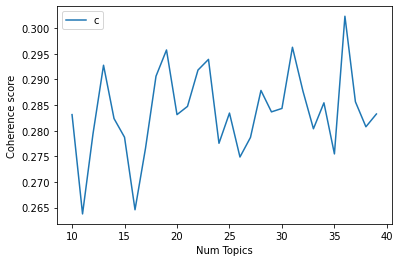

In [14]:
import matplotlib.pyplot as plt 
x = range(10,40)
plt.plot(x,coherence_values) 
plt.xlabel("Num Topics") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()


In [15]:
coherences= pd.DataFrame()
coherences['coherences']=coherence_values
coherences['number of topics']=x
new_df=coherences.nlargest(4,'coherences')

In [16]:


topics_range = new_df['number of topics'].tolist()
topics_range

[36, 31, 19, 23]

For the tuning part we used this website as reference:
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0?fbclid=IwAR2-0x0Z-VXdit0RfiFhzAW5ZyZhVUMkpKMbPgckYPpiV_gzcUCfMSovq_g

Then, we choose 4 top number of topics with the highest coherence.  Those are 36, 31, 19 and 23. Afterwards, we tune our model over these topics and parameters alpha and beta. It is done in order to choose the model with the best coherence.

In [17]:

# we tune all 3 of parameters using the function below 

from gensim.models import CoherenceModel
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda, texts=processed_description, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()



# Topics range

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

num_of_docs = len(corpus)


model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }


for k in topics_range:
            # iterate through alpha values
    for a in alpha:
                # iterare through beta values
        for b in beta:
                    # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                #model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

df_results = pd.DataFrame(model_results)
best = df_results.iloc[df_results['Coherence'].idxmax()]

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [18]:
df_results


,Topics,Alpha,Beta,Coherence
0,36,0.01,0.01,0.284429
1,36,0.01,0.31,0.286792
2,36,0.01,0.61,0.286651
3,36,0.01,0.91,0.283363
4,36,0.01,symmetric,0.282253
...,...,...,...,...
115,23,asymmetric,0.01,0.303229
116,23,asymmetric,0.31,0.287431
117,23,asymmetric,0.61,0.282029
118,23,asymmetric,0.91,0.295722


In [19]:
best #displaying the coefficients for the best model

Topics               23
Alpha        asymmetric
Beta               0.01
Coherence      0.303229
Name: 115, dtype: object

We obtain that the model with the best coherence contains 23 topics and has asymmetric alpha and beta equal to 0.01. 

In [20]:
#applying the best model obtained 
lda = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=best['Topics'], 
                                           alpha=best['Alpha'],
                                           eta=best['Beta'],
                                           per_word_topics=True)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Now that we found the optimal parameters we can apply our model and fit it to our data. Below you can see each topic wordcloud:

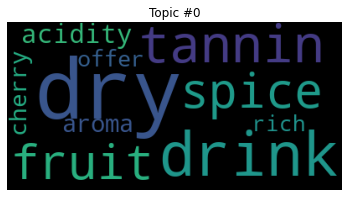

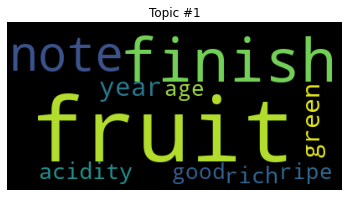

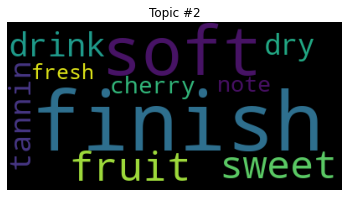

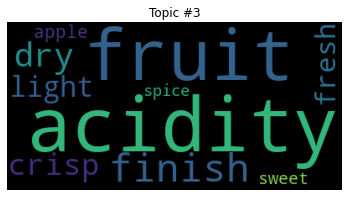

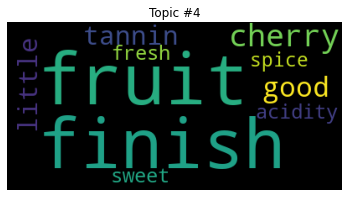

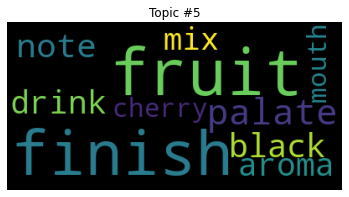

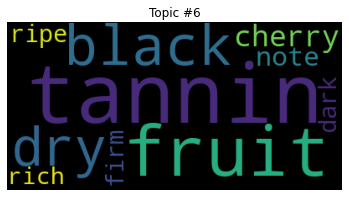

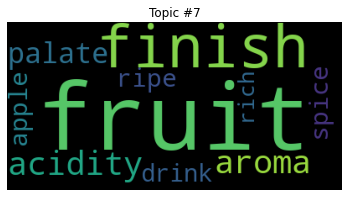

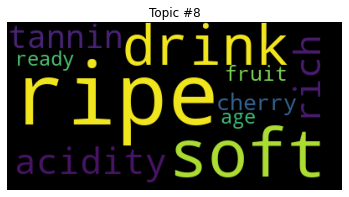

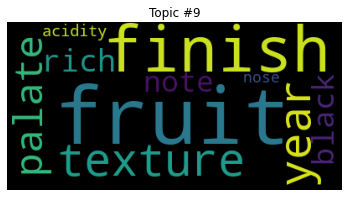

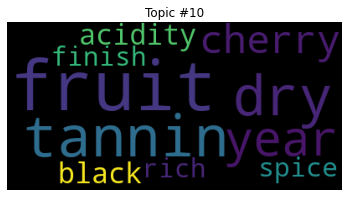

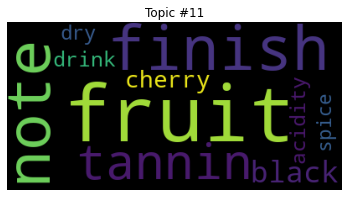

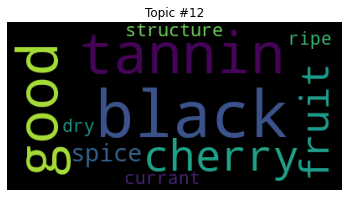

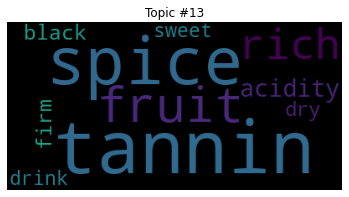

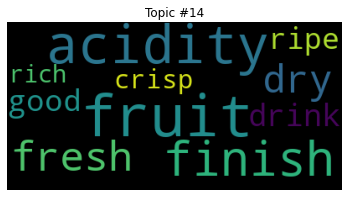

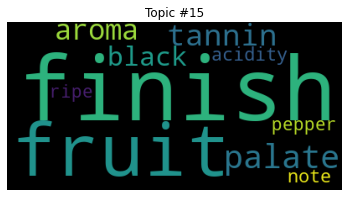

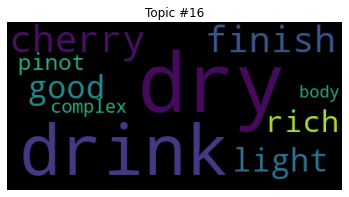

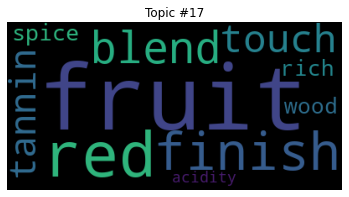

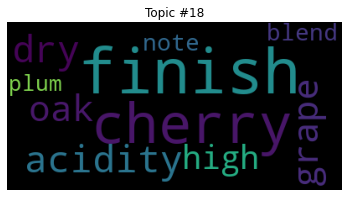

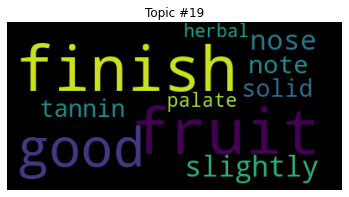

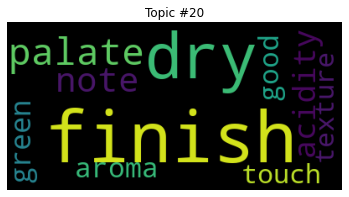

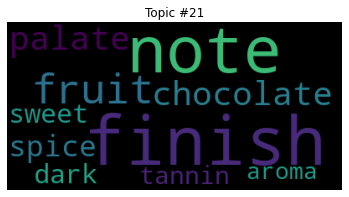

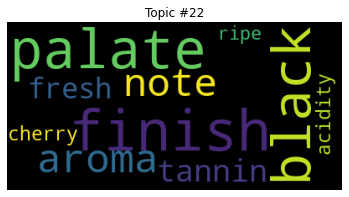

In [21]:
#visualizing the composition of each topic
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()


Now we try to understand about what each topic is talking about, based on the key words :

Topic 0: Cherry, fruit, spice, acifity, dry: It could be about some dry wine, whith fruit taste. Spice could mean that there are some spicy notes.

Topic 1: Green, fruit, age: It seemes that this topic is about some white wine, whith some fruit taste. Based on the word age we could think of 'old' or 'young' wines.

Topic 2: Sweet, tannin, fruit, fresh: It is about some rose or white winr (as the red wine is usually drunk not fresh). The taste is sweet with some fruit taste.

Topic 3: Crisp, light, acidity, apple, fresh: Some light wine (probably white). If we search for the meaning of crisp it means: 'Crispness is a positive quality in wine, usually whites, that is caused by acidity. It refers specifically to the fresh, brisk or firm feeling in the mouth. '

Topic 4:Fresh, fruit, cherry, spice, sweet: Again it is about some sweet, fruit wine with some spicy taste.

Topic 5: Cherry, black, mix, finish, palate. As for 'palate', the meaning is : 'refers to the ability to identify and taste different characteristics of wine. Wine drinkers and wine tasters develop their palate by using visual assessment, smelling the wine and tasting the wine'.Thus, it seems that this topic is  a little ambigu. 

Topic 6: Cherry, dry, firm, fruit, black: It speaks about some dark wine, with probably fruit notes. 

Topic 7: Apple, finish, fruit, acidity, spice: Probably some light wine with fuit taste, maybe some notes of apple taste. A little bit acid and spicy.


Topic 8: Ready, age, fruit, cherry, soft, acidity: This topis seems to speak about some old wine (based on words age and ready), probably red. Soft vould mean with few degrees of alcohol. 

Topic 9: Black, acidity, fruit: This topic is some dark wine,  a little bit acid and with fruit taste. Maybe this topic is not very representative. 

Topic 10: Fruit, spice, black, acidity, cherry: Based on the key words, this topic is somewhat similar to the Topic 6.

Topic 11: Fruit, cherry, acidity, dry, spice: Same as for Topic 10.

Topic 12: Currant, fruit, cherry, spice: Based on the word 'currant', it should speak about th light, sweet, fruit, fresh and tart wine.

Topic 13: Fruit, spice, dry, acidity, black, tannin:  It is si,ilar to the topic 10, but with probably some tannin taste.

Topic 14: Crisp, dry, fruit, fresh: This topic is probably about some dry white wine with fruit notes.

Topic 15: Black, pepper, palate, fruit: It is probably about some red wine with somewhat spicy and fruit taste.

Topic 16: Pinot, complex, dry, light, cherry: Based ont he word 'pinot', one should for sure think of some Pinot Noir or this sirt of wine.

Topic 17: Red, blend, tannin, wood: Unlike other topics, this topic differs a lot from others. It would be easier to assign some name to it for 'true somelliers' . Probably about some red wine, which stayed a lot in the wine cave (in some wood barrel).

Topic 18: Blend, oak, high, plum, acidity: Plum after searching on the Internet “Plum wine, or umeshu, is a liqueur made by steeping ume, or the Japanese plum, in some sort of liquor”. So this topic probably talks about this type of wine.

Topic 19: Slightly, herbal, fruit, palate: Probably some wine with herbal and fruit notes.

Topic 20: Dry, acidity, green, age: This topic talks about the age of the wine, it's coulour and the dry taste. 

Topic 21: Chocolate, fruit,spice, aroma: Interesting mix of words. But it is difficult to find an interpretation for this topic.

Topic 22: Cherry, black, acidity, fresh: very similar to the topic 6, 9, 10, 11 and 13.


As we can see from the main topic words, there is a big part of them which are not very useful, while they use almost the same words. These topics are 6,
9, 10, 11 and 13. We couls for example use instead only one topic. Some alternative would be to remove some words which could are not very representable and potentially could produce some noise. These words are for example: drink, offer or palate (which is similar in the meaning to taste).






In [22]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [23]:
#displaying the results of LDA from usinf another technique
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.022605 -0.017764       1        1  6.092142
3     -0.029407 -0.038344       2        1  6.033086
8      0.059266 -0.058568       3        1  5.357700
6      0.043615  0.013191       4        1  5.328195
5     -0.038642  0.022390       5        1  5.259994
1     -0.000267 -0.015519       6        1  5.193588
13     0.066205  0.008677       7        1  4.940807
10     0.083884 -0.027550       8        1  4.833776
16    -0.000979 -0.048753       9        1  4.787636
14    -0.012743 -0.044424      10        1  4.690822
20    -0.124623 -0.040030      11        1  4.668586
12     0.069819  0.049044      12        1  4.596095
4      0.001793 -0.009965      13        1  4.331072
21    -0.024806  0.059168      14        1  4.230058
2      0.005416 -0.007997      15        1  4.055416
15    -0.030843  0.045183      16        1  3.641344
11    -0.000186  0.027866      17        1  3.555101
7     -0.016780  0.001086      18        1  3.533401
19    -0.026248  0.067234      19        1  3.300873
22    -0.014888  0.054102      20        1  3.144301
17     0.016847 -0.004670      21        1  2.866861
9     -0.001622 -0.006413      22        1  2.843537
18    -0.047415 -0.027944      23        1  2.715609, topic_info=       Term          Freq         Total Category  logprob  loglift
6    finish   8947.000000   8947.000000  Default  30.0000  30.0000
8     fruit  10391.000000  10391.000000  Default  29.0000  29.0000
108    note   4646.000000   4646.000000  Default  28.0000  28.0000
24   tannin   6449.000000   6449.000000  Default  27.0000  27.0000
61    black   4319.000000   4319.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
8     fruit     92.575530  10391.412371  Topic23  -4.7848  -1.1146
87   palate     82.520758   4698.719563  Topic23  -4.8997  -0.4358
42     rich     78.463154   4285.368767  Topic23  -4.9501  -0.3942
20     ripe     78.010202   4372.681599  Topic23  -4.9559  -0.4201
71    offer     72.578687   2558.914871  Topic23  -5.0281   0.0435

[1541 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
324       1  0.059161  absolutely
324       2  0.153818  absolutely
324       3  0.035496  absolutely
324       4  0.106489  absolutely
324       5  0.059161  absolutely
...     ...       ...         ...
602      11  0.047131   zinfandel
602      13  0.109973   zinfandel
602      14  0.031421   zinfandel
602      16  0.047131   zinfandel
602      18  0.015710   zinfandel

[13508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 9, 7, 6, 2, 14, 11, 17, 15, 21, 13, 5, 22, 3, 16, 12, 8, 20, 23, 18, 10, 19])

In [24]:
t=[]
for d in df2:
    bow = dictionary.doc2bow(d.split())
    t.append(lda.get_document_topics(bow))
#applying the model obtained to our reviews and see which results do we obtain for each review


In [25]:
t

[[(5, 0.53837425), (16, 0.39095098)],
 [(0, 0.016139211), (1, 0.013347509), (2, 0.011382119), (4, 0.8659239)],
 [(0, 0.018826224),
  (1, 0.0155711705),
  (2, 0.013278927),
  (3, 0.011575551),
  (4, 0.010259516),
  (10, 0.83942145)],
 [(0, 0.58246), (21, 0.33880123)],
 [(0, 0.0102693355), (2, 0.52173793), (11, 0.3977052)],
 [(16, 0.91882795)],
 [(3, 0.92244506)],
 [(4, 0.9217889)],
 [(0, 0.010270596), (4, 0.17334628), (8, 0.456289), (11, 0.29200646)],
 [(0, 0.010269533), (12, 0.52788115), (13, 0.38689888)],
 [(15, 0.15739606), (17, 0.4041299), (21, 0.37667993)],
 [(4, 0.42359528), (19, 0.50008935)],
 [(20, 0.9247498)],
 [(0, 0.018826582),
  (1, 0.8488929),
  (2, 0.013279159),
  (3, 0.011575587),
  (4, 0.010259517)],
 [(0, 0.0141176395), (1, 0.011678961), (7, 0.8807308)],
 [(0, 0.0125488285), (1, 0.010381568), (5, 0.24156594), (7, 0.65855825)],
 [(4, 0.932962)],
 [(0, 0.016148938), (1, 0.013348295), (2, 0.011382121), (3, 0.8670414)],
 [(0, 0.010272904), (6, 0.6269942), (14, 0.28926393)],

In [26]:
res=pd.DataFrame(t)

In [27]:
res

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,"(5, 0.53837425)","(16, 0.39095098)",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"(0, 0.016139211)","(1, 0.013347509)","(2, 0.011382119)","(4, 0.8659239)",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"(0, 0.018826224)","(1, 0.0155711705)","(2, 0.013278927)","(3, 0.011575551)","(4, 0.010259516)","(10, 0.83942145)",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"(0, 0.58246)","(21, 0.33880123)",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,"(0, 0.0102693355)","(2, 0.52173793)","(11, 0.3977052)",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,"(0, 0.55684173)","(10, 0.36583802)",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
29996,"(7, 0.3490083)","(14, 0.5892993)",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
29997,"(0, 0.010270672)","(13, 0.91184866)",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
29998,"(0, 0.010272983)","(19, 0.9111486)",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [28]:
des=list(df2)
len(des)

30000

In [29]:
res['description']=des#putting together the topics probabilities and the reviews

In [30]:
res.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,description
0,"(5, 0.53837425)","(16, 0.39095098)",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,The color and aromas are true to both Pinot No...
1,"(0, 0.016139211)","(1, 0.013347509)","(2, 0.011382119)","(4, 0.8659239)",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"This is a standard, everyday Zinfandel that's ..."
2,"(0, 0.018826224)","(1, 0.0155711705)","(2, 0.013278927)","(3, 0.011575551)","(4, 0.010259516)","(10, 0.83942145)",None,None,None,None,...,None,None,None,None,None,None,None,None,None,The top wine in the Rocim range is produced fr...
3,"(0, 0.58246)","(21, 0.33880123)",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,Pietro Clementi's fresh Ripasso is redolent of...
4,"(0, 0.0102693355)","(2, 0.52173793)","(11, 0.3977052)",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,Falezza's Ripasso opens with an awkward nose t...


In [31]:
#res.to_csv('assigned_topic_probabilities.csv')

Let's look inside the reviews and the topics assigned to those. 

'The color and aromas are true to both Pinot Noir and Chile's Pinot-friendly Casablanca Valley. Dried fruit, citrus and pie cherry aromas take it toward a potpourri of red-fruit flavors. The only weakness is that the feel is a bit choppy and the finish goes heavy on the toast and woodspice. A good but imperfect effort at a more serious Chilean Pinot. ' For this review topic 5 and topic 16 is assigned, with topic 5 having higher probability. (Topis 16 is about Pinot and would be more represantative).


'This is a standard, everyday Zinfandel that's rugged and needs meats and cheeses to tame it. It's rough in tannins and dry, with a strange acidity accompanying ripe to overripe flavors of blackberries, currants and pepper.' - Zinfandel is a red wine (based ont he topic words one would have assigned topic 12 to this wine, but we can see that this topic doesn't even appear in the list of assigned probabilities. (pnly topic 0, 1, 2, and 4 appear with 4 having the highest probability)

'The top wine in the Rocim range is produced from selected Alicante Bouschet grapes. It is huge and powerful, perhaps too much in its concentration, richness and density. Dark and brooding, it is super everything and certainly needs to calm down. Drink from 2019.' -Topics 0,1,2,3,4 and 10 are assigned with 10 having the highest probability. But it is not at all obvious which topic suits the best. 


The results shown above can be exaplained by the fact that the coherence of our topics above were pretty low, thus the LDA model did not perform very well, cerating some topics which are in fact useful.





